# **Step 2: Model Building and Training**

## **1. Import Libraries**

In [1]:
#Import some required packages and libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
import csv
import requests
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore")
from io import StringIO
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
!pip install wordcloud sastrawi
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, SpatialDropout1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 8.8 MB/s eta 0:00:00


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## **2. Load Dataset**

In [2]:
#Load the dataset from a CSV file
df = pd.read_csv("ulasan_satusehat.csv")

In [3]:
#Show the first 5 rows of a dataframe from a CSV file
df.head()

,id_review,username,ulasan,rating,tanggal,jumlah_like,versi_aplikasi
0,9840fba0-23cf-4a55-8c05-b79fe12b0dca,Pengguna Google,tidak bisa login. disuruh masukkan email dan s...,1,2025-04-03 03:39:49,0,8.0.1
1,6a065b4f-bae8-4b97-9a04-78d2ded15b5e,Pengguna Google,"tolong lah lebih diperbaiki lagi kualitasnya, ...",1,2025-04-02 23:34:30,0,8.0.1
2,564b4bea-08cb-457e-85cb-3e4a79bc1447,Pengguna Google,"Setelah mengganti aplikasi, bukannya semakin b...",1,2025-04-02 15:26:14,0,NaN
3,c1913ce9-825f-4135-8764-d4d1765252e8,Pengguna Google,Sudah bisa login tapi selalu gagal di masukkan...,2,2025-04-02 15:14:07,0,NaN
4,a07a44d4-bdd4-4e5f-a75f-6e7065815cc4,Pengguna Google,"aplikasi selalu eror, stuck dibagian edit biod...",1,2025-04-02 15:10:19,0,NaN


In [4]:
#Review the number of rows and columns in the dataset
print(f"Number of rows: {df.shape[0]}")
print(f"Number of columns: {df.shape[1]}")

Number of rows: 100000
Number of columns: 7


In [5]:
#Check columns and data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   id_review       100000 non-null  object
 1   username        100000 non-null  object
 2   ulasan          100000 non-null  object
 3   rating          100000 non-null  int64 
 4   tanggal         100000 non-null  object
 5   jumlah_like     100000 non-null  int64 
 6   versi_aplikasi  81135 non-null   object
dtypes: int64(2), object(5)
memory usage: 5.3+ MB


In [6]:
#Show overall descriptive statistics
df.describe(include="all")

,id_review,username,ulasan,rating,tanggal,jumlah_like,versi_aplikasi
count,100000,100000,100000,100000.000000,100000,100000.000000,81135
unique,100000,1000,70274,NaN,99645,NaN,113
top,e8e170fe-3dea-4472-b572-e1ab57b6f14b,Pengguna Google,Ok,NaN,2023-03-01 01:31:42,NaN,5.2.0
freq,1,99000,4265,NaN,4,NaN,5324
mean,NaN,NaN,NaN,2.927260,NaN,1.077910,NaN
std,NaN,NaN,NaN,1.853225,NaN,27.523027,NaN
min,NaN,NaN,NaN,1.000000,NaN,0.000000,NaN
25%,NaN,NaN,NaN,1.000000,NaN,0.000000,NaN
50%,NaN,NaN,NaN,3.000000,NaN,0.000000,NaN
75%,NaN,NaN,NaN,5.000000,NaN,0.000000,NaN


## **3. Exploratory Data Analysis (EDA)**

In [7]:
#Check the number of missing values
df.isna().sum()

,0
id_review,0
username,0
ulasan,0
rating,0
tanggal,0
jumlah_like,0
versi_aplikasi,18865


In [8]:
#Check the number of duplicate rows
df.duplicated().sum()

np.int64(0)

In [9]:
#Check the number of duplicate columns
df.columns.duplicated()

array([False, False, False, False, False, False, False])

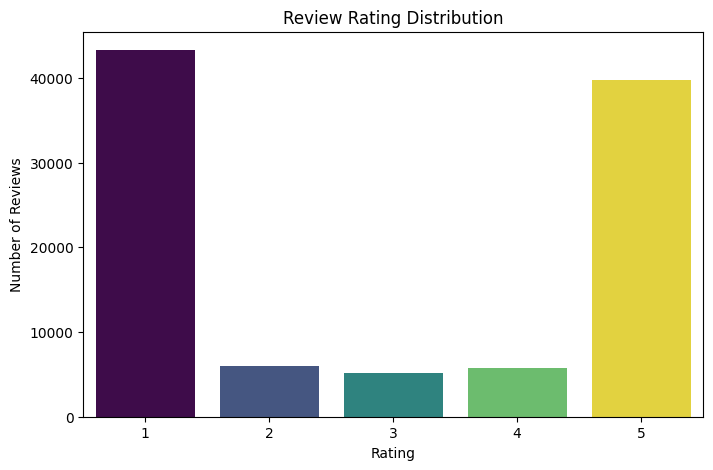

In [10]:
#Rating distribution visualization
plt.figure(figsize=(8,5))
sns.countplot(data=df, x="rating", hue="rating", palette="viridis", legend=False)
plt.title("Review Rating Distribution")
plt.xlabel("Rating")
plt.ylabel("Number of Reviews")
plt.show()

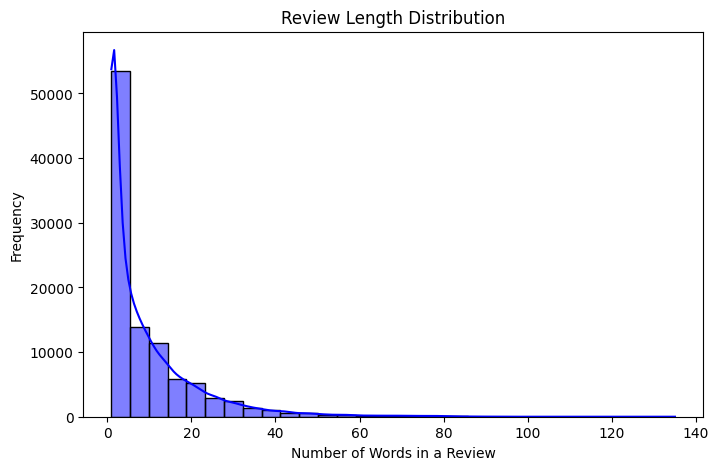

In [11]:
#Check Review Length Distribution
df["panjang_ulasan"] = df["ulasan"].apply(lambda x: len(x.split()))
plt.figure(figsize=(8,5))
sns.histplot(df["panjang_ulasan"], bins=30, kde=True, color="blue")
plt.title("Review Length Distribution")
plt.xlabel("Number of Words in a Review")
plt.ylabel("Frequency")
plt.show()

## **4. Text Preprocessing**

In [12]:
#Delete versi_aplikasi column (Delete Column)
df.drop(columns=["versi_aplikasi"], inplace=True)

In [13]:
#Clean text for sentiment analysis (Cleaning Text)
def cleanText(text):
    text = text.lower() #Convert text to lowercase
    text = re.sub(r'@[A-Za-z0-9]+', '', text) #Remove mentions (@username)
    text = re.sub(r'#[A-Za-z0-9]+', '', text) #Remove hashtags (#hashtag)
    text = re.sub(r"http\S+", '', text) #Remove URLs (https://...)
    text = re.sub(r'[^\w\s,]', '', text, flags=re.UNICODE) #Remove emojis
    text = re.sub(r'\d+', '', text) #Remove numbers
    text = text.replace('\n', ' ') #Replace newlines with space
    text = text.translate(str.maketrans('', '', string.punctuation)) #Remove all punctuation
    text = text.strip(' ') #Remove leading and trailing spaces
    return text

In [14]:
#Split the text into individual word tokens (Tokenization)
def tokenText(text):
    text = word_tokenize(text)
    return text

In [15]:
#Dictionary of slang words and their standard equivalents
slangwords = {
    "@": "di", "abis": "habis", "masi": "masih", "bgt": "banget", "maks": "maksimal",
    "tp": "tapi", "jd": "jadi", "krn": "karena", "trs": "terus", "good": "bagus",
    "dmn": "dimana", "hrs": "harus", "sy": "saya", "sm": "sama", "very good": "mantap",
    "utk": "untuk", "sbg": "sebagai", "blm": "belum", "udh": "sudah", "sdh": "sudah",
    "skrg": "sekarang", "dpt": "dapat", "tdk": "tidak", "bs": "bisa", "gk": "tidak",
    "dr": "dari", "dg": "dengan", "aja": "saja", "smua": "semua", "ngk": "tidak",
    "apk": "aplikasi", "dev": "developer", "bug": "kesalahan", "jlk": "jelek",
    "crash": "gagal", "sgt": "sangat", "fitur": "fungsi", "kcw": "kecewa", "g": "tidak",
    "err": "error", "eror": "error", "lag": "lambat", "bgs": "bagus", "gagal load": "gagal memuat",
    "ngebug": "bermasalah", "lemot": "lambat", "bagu": "bagus", "gabisa": "tidak bisa",
    "kehapus": "terhapus", "ribet": "sulit", "males": "tidak mau", "terimakasih": "terima kasih",
    "gampang": "mudah", "cepet": "cepat", "error": "kesalahan", "ngga": "tidak",
    "coba2": "mencoba", "cape": "capek", "drpd": "daripada", "ampun": "parah",
    "parah": "buruk", "mantep": "mantap", "makasih": "terima kasih", "gpp": "tidak apa-apa",
    "bbrp": "beberapa", "syg": "sayang", "dmna": "dimana", "lg": "lagi",
    "stuck": "macet", "gmn": "gimana", "kliatan": "kelihatan", "ampas": "buruk",
    "gajelas": "tidak jelas", "gaje": "tidak jelas", "kalo": "kalau", "td": "tadi",
    "gt": "gitu", "gitu": "begitu", "org": "orang", "blg": "bilang", "tlg": "tolong",
    "ak": "aku", "gw": "saya", "loe": "kamu", "lo": "kamu", "gua": "saya",
    "bro": "saudara", "sis": "saudari", "kmrn": "kemarin", "br": "baru",
    "btw": "ngomong-ngomong", "tq": "terima kasih", "kpn": "kapan", "bnr": "benar",
    "knp": "kenapa", "bkn": "bukan", "aneh": "tidak biasa", "cmn": "cuman",
    "cm": "cuma", "kyk": "seperti", "krna": "karena", "yg": "yang", "cringe": "memalukan",
    "lah": "", "sih": "", "jgn": "jangan", "uda": "sudah", "gws": "sehat selalu",
    "maap": "maaf", "ajg": "anjing", "anjir": "anjing", "mantul": "mantap betul",
    "cmiiw": "correct me if I'm wrong", "afk": "away from keyboard",
    "plis": "tolong", "kl": "kalau", "pdhl": "padahal", "udah": "sudah",
    "jdwl": "jadwal", "pk": "pakai", "prnh": "pernah", "ky": "kayak",
    "trmksh": "terima kasih", "sbnrnya": "sebenarnya", "smpe": "sampai",
    "jdul": "judul", "cpt": "cepat", "tlpn": "telepon", "bsok": "besok",
    "sjk": "sejak", "gaada": "tidak ada", "gmna": "bagaimana", "mo": "mau",
    "bbrapa": "beberapa", "sdikit": "sedikit", "lbih": "lebih", "msh": "masih",
    "ntr": "nanti", "gtw": "gak tau", "kek": "seperti", "mnding": "mendingan",
    "aj": "saja", "ni": "ini", "da": "sudah", "ogut": "saya", "noob": "pemula",
    "mauu": "mau", "mls": "malas", "bngt": "banget", "mksd": "maksud",
    "trnyata": "ternyata", "cb": "coba", "blh": "boleh", "prcma": "percuma",
    "ktmu": "ketemu", "dlu": "dulu", "bener": "benar", "bner": "benar",
    "kesel": "kesal", "mendingan": "lebih baik", "biar": "supaya",
    "akhlak": "moral", "dah": "sudah", "skli": "sekali", "download": "instal"
}

In [16]:
#Replace slang words with their standard equivalents.
def replaceSlang(text):
    return ' '.join(slangwords.get(word.lower(), word) for word in text.split())

In [17]:
#Remove stopwords from the text (Stopword Removal)
def filterText(text):
    listStopwords = set(stopwords.words("indonesian")) #Load Indonesian stopwords
    listStopwords1 = set(stopwords.words("english")) #Load English stopwords
    listStopwords.update(listStopwords1) #Combine Indonesian and English stopwords
    listStopwords.update([
        "iya", "yaa", "gak", "gk", "nya", "na", "sih", "ku", "di", "ga", "ya", "gaa", "loh", "kah", "woi", "woii", "woy",
        "dong", "deh", "nih", "tuh", "klo", "mah", "lho", "kan", "kayak", "banget", "aja", "kok", "sama", "gitu", "dah",
        "lah", "tau", "udah", "belum", "emang", "eh", "masa", "kayaknya", "soalnya", "gimana", "kenapa", "pokoknya",
        "apalagi", "terus", "mending", "bakal", "tapi", "padahal", "walaupun", "daripada", "abis", "doang", "sangat",
        "sekali", "lebih", "paling", "tetep", "tetapi", "sampe", "makanya", "ke", "buat", "biar", "hampir",
        "bukan", "malah", "meskipun", "mungkin", "so", "tp", "jd", "jg", "krn", "trs", "dmn", "hrs", "sy", "saya",
        "anda", "kamu", "kalian", "dia", "mereka", "kita", "aku", "gua", "gw", "lu", "loe"
    ]) #Add custom stopwords
    filtered = [txt for txt in text if txt not in listStopwords]
    text = filtered
    return text

In [18]:
#Stemming Process using Sastrawi Library
factory = StemmerFactory()
stemmer = factory.create_stemmer()
def stemmingText(words):
    return [stemmer.stem(word) for word in words]

In [19]:
#Convert a list of words into sentences
def toSentence(list_words):
    return ' '.join(list_words)

In [20]:
#Cleans the text and stores it in the 'txt_clean' column
df['txt_clean'] = df['ulasan'].apply(cleanText)
#Replace slang words with standard words and save them in 'txt_slangwords'
df['txt_slangwords'] = df['txt_clean'].apply(replaceSlang)
#Split the text into tokens (words) and store them in 'txt_tokenText'
df['txt_tokenText'] = df['txt_slangwords'].apply(tokenText)
#Remove stop words (common words) and store them in 'txt_stopword'
df['txt_stopword'] = df['txt_tokenText'].apply(filterText)
#Stemming the text and saving it in 'txt stemming'
df['txt_stemming'] = df['txt_stopword'].apply(stemmingText)
#Combine tokens into a sentence and store it in 'fix_text'
df['fix_text'] = df['txt_stemming'].apply(toSentence)

In [21]:
#Show dataframe
df

,id_review,username,ulasan,rating,tanggal,jumlah_like,panjang_ulasan,txt_clean,txt_slangwords,txt_tokenText,txt_stopword,txt_stemming,fix_text
0,9840fba0-23cf-4a55-8c05-b79fe12b0dca,Pengguna Google,tidak bisa login. disuruh masukkan email dan s...,1,2025-04-03 03:39:49,0,40,tidak bisa login disuruh masukkan email dan su...,tidak bisa login disuruh masukkan email dan su...,"[tidak, bisa, login, disuruh, masukkan, email,...","[login, disuruh, masukkan, email, email, kode,...","[login, suruh, masuk, email, email, kode, veri...",login suruh masuk email email kode verifikasi ...
1,6a065b4f-bae8-4b97-9a04-78d2ded15b5e,Pengguna Google,"tolong lah lebih diperbaiki lagi kualitasnya, ...",1,2025-04-02 23:34:30,0,12,tolong lah lebih diperbaiki lagi kualitasnya m...,tolong lebih diperbaiki lagi kualitasnya mau ...,"[tolong, lebih, diperbaiki, lagi, kualitasnya,...","[tolong, diperbaiki, kualitasnya, login, nungg...","[tolong, baik, kualitas, login, nunggunya]",tolong baik kualitas login nunggunya
2,564b4bea-08cb-457e-85cb-3e4a79bc1447,Pengguna Google,"Setelah mengganti aplikasi, bukannya semakin b...",1,2025-04-02 15:26:14,0,67,setelah mengganti aplikasi bukannya semakin ba...,setelah mengganti aplikasi bukannya semakin ba...,"[setelah, mengganti, aplikasi, bukannya, semak...","[mengganti, aplikasi, memburuk, pedulilindungi...","[ganti, aplikasi, buruk, pedulilindungi, masuk...",ganti aplikasi buruk pedulilindungi masuk suli...
3,c1913ce9-825f-4135-8764-d4d1765252e8,Pengguna Google,Sudah bisa login tapi selalu gagal di masukkan...,2,2025-04-02 15:14:07,0,38,sudah bisa login tapi selalu gagal di masukkan...,sudah bisa login tapi selalu gagal di masukkan...,"[sudah, bisa, login, tapi, selalu, gagal, di, ...","[login, gagal, masukkan, pin, pin, masukkan, m...","[login, gagal, masuk, pin, pin, masuk, masuk, ...",login gagal masuk pin pin masuk masuk email ub...
4,a07a44d4-bdd4-4e5f-a75f-6e7065815cc4,Pengguna Google,"aplikasi selalu eror, stuck dibagian edit biod...",1,2025-04-02 15:10:19,0,25,aplikasi selalu eror stuck dibagian edit bioda...,aplikasi selalu error macet dibagian edit biod...,"[aplikasi, selalu, error, macet, dibagian, edi...","[aplikasi, error, macet, dibagian, edit, bioda...","[aplikasi, error, macet, bagi, edit, biodata, ...",aplikasi error macet bagi edit biodata ubah pi...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,ef826865-cc72-456b-889f-9162666fa61a,Sri Dayat,Aplikasi ya mantap....jgn lp...di donlot,4,2022-02-25 15:17:13,0,5,aplikasi ya mantapjgn lpdi donlot,aplikasi ya mantapjgn lpdi donlot,"[aplikasi, ya, mantapjgn, lpdi, donlot]","[aplikasi, mantapjgn, lpdi, donlot]","[aplikasi, mantapjgn, lpdi, donlot]",aplikasi mantapjgn lpdi donlot
99996,8c4ef307-7e1b-4bf7-9ae5-cfb823408fad,Su Yanto,Ok,5,2022-02-25 15:09:16,0,1,ok,ok,[ok],[ok],[ok],ok
99997,371d6a78-c9fe-44be-9c39-e505d80aec8d,Atin Andriyani,Tolng d permudah dong pncarian tggl lahir nya....,3,2022-02-25 15:07:20,0,13,tolng d permudah dong pncarian tggl lahir nya ...,tolng d permudah dong pncarian tggl lahir nya ...,"[tolng, d, permudah, dong, pncarian, tggl, lah...","[tolng, permudah, pncarian, tggl, lahir, susah]","[tolng, mudah, pncarian, tggl, lahir, susah]",tolng mudah pncarian tggl lahir susah
99998,c44561c0-030f-438b-8533-1c17591f6a78,Made Parta,"Aplikasinya bagus, cuma dibagian input tanggal...",3,2022-02-25 15:01:55,9,28,aplikasinya bagus cuma dibagian input tanggal ...,aplikasinya bagus cuma dibagian input tanggal ...,"[aplikasinya, bagus, cuma, dibagian, input, ta...","[aplikasinya, bagus, dibagian, input, tanggal,...","[aplikasi, bagus, bagi, input, tanggal, lahir,...",aplikasi bagus bagi input tanggal lahir lambat...


## **5. Labeling**

In [42]:
#Lexicon Preparation
def fetch_lexicon(url):
    response = requests.get(url)
    if response.status_code == 200:
        return {word.strip() for word in response.text.split("\n") if word.strip()}
    print(f"Failed to fetch {url}, status code: {response.status_code}")
    return set()
lexicon_urls = {
    "positive": "https://raw.githubusercontent.com/masdevid/ID-OpinionWords/master/positive.txt",
    "negative": "https://raw.githubusercontent.com/masdevid/ID-OpinionWords/master/negative.txt"
}
lexicons = {key: fetch_lexicon(url) for key, url in lexicon_urls.items()}

positive_words = [
    "bagus", "mantap", "cepat", "puas", "senang", "baik", "suka", "gampang", "mudah", "sukses",
    "lebih mudah", "serba mudah", "keren", "nyaman", "menarik", "membantu", "praktis", "top",
    "terbaik", "bantu", "memuaskan", "manfaat", "cocok", "lancar", "enak", "positif", "fantastis"
]
netral_words = [
    "aplikasi", "vaksin", "satusehat", "peduli lindungi", "booster", "orang", "otp",
    "sertifikat", "login", "sehat", "pemerintah", "informasi", "upgrade", "update", "pengguna", "server",
    "waktu", "proses", "data", "perangkat", "versi", "pengaturan"
]
negative_words = [
    "buruk", "lama", "payah", "error", "tidak", "jelek", "lelet", "kecewa", "penipuan",
    "eror", "kurang", "berat", "bego", "lambat", "susah", "masalah", "gagal", "buruk banget","tidak responsif",
    "error terus", "tidak memadai", "banyak masalah", "tidak bisa", "terlalu lama", "gangguan", "fatal", "tidak aman",
    "rusak", "bingung", "sulit"
]

lexicons["positive"].update(positive_words)
lexicons["negative"].update(negative_words)
for sentiment, words in lexicons.items():
    print(f"Total {sentiment} words: {len(words)}")

Total positive words: 1190
Total negative words: 2413


In [43]:
#Sentiment Analysis Function
def get_sentiment(text):
    score = sum(
        (1 if word in lexicons["positive"] else -1 if word in lexicons["negative"] else 0)
        for word in text
    )
    sentiment = "positive" if score > 0 else "negative" if score < 0 else "neutral"
    return score, sentiment

In [44]:
#Determining sentiment scores and labels
results = df['txt_stemming'].apply(get_sentiment)
results = list(zip(*results))
df['sentiment_score'] = results[0]
df['sentiment'] = results[1]

## **6. Exploration Label**

In [45]:
#Shows the number of words per sentiment
print(df['sentiment'].value_counts())

sentiment
neutral     48500
positive    36204
negative    15296
Name: count, dtype: int64


In [90]:
#Shows 10 texts with sentiment results
print(df[['sentiment', 'fix_text']].sample(10))
print(df['fix_text'].isna().sum())

      sentiment                                           fix_text
65260  positive                                              bagus
85809   neutral         sertifikat vaksin boster kmna muncul mucul
18484  positive                                       bagus baharu
75105   neutral                                                oke
53507   neutral       vaksin dosis sertifikat kadang kadang hilang
82736   neutral                                               coba
34144  negative     login bulan daftar kecewa moga aplikasi lenyap
52958   neutral                                                 ok
32163  negative  update satusehat app tanggal lahir sertificate...
58948  positive                                              bagus
0


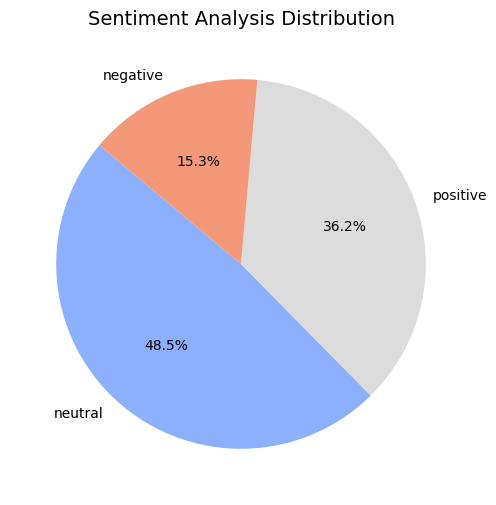

In [91]:
#Sentiment distribution visualization
sentiment_counts = df["sentiment"].value_counts()
palette = sns.color_palette("coolwarm", n_colors=len(sentiment_counts))
plt.figure(figsize=(8, 6))
plt.pie(
    sentiment_counts,
    labels=sentiment_counts.index,
    autopct='%1.1f%%',
    colors=palette,
    startangle=140,
)
plt.title("Sentiment Analysis Distribution", fontsize=14)
plt.show()

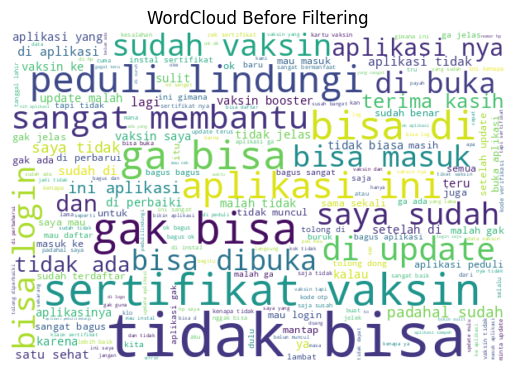

In [48]:
#WordCloud visualization before filtering
text_before_filtering = ' '.join(df['txt_slangwords'])
wordcloud_before = WordCloud(width=600, height=400, background_color='white').generate(text_before_filtering)
plt.imshow(wordcloud_before, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud Before Filtering")
plt.show()

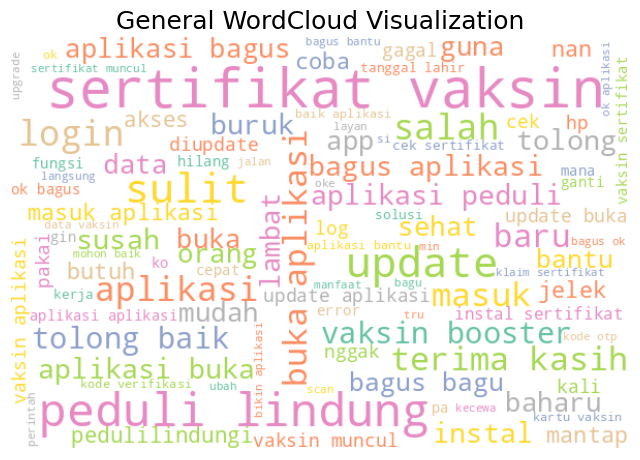

In [49]:
#General WordCloud Visualization
list_words = ' '.join(df['txt_stemming'].dropna().explode().astype(str))
wordcloud = WordCloud(width=600, height=400, background_color='white', colormap='Set2', min_font_size=10).generate(list_words)
plt.figure(figsize=(8, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('General WordCloud Visualization', fontsize=18)
plt.show()

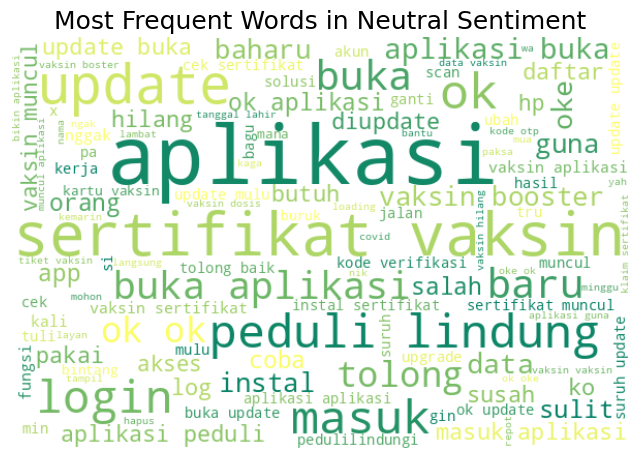

In [50]:
#Neutral Sentiment Visualization
neutral_text = df[df['sentiment'] == 'neutral'].sort_values(by='sentiment_score', ascending=False)
list_words = ' '.join(neutral_text['txt_stemming'].explode().dropna().astype(str))
wordcloud = WordCloud(width=600, height=400, background_color='white', colormap='summer', min_font_size=10).generate(list_words)
plt.figure(figsize=(8, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Frequent Words in Neutral Sentiment', fontsize=18)
plt.show()

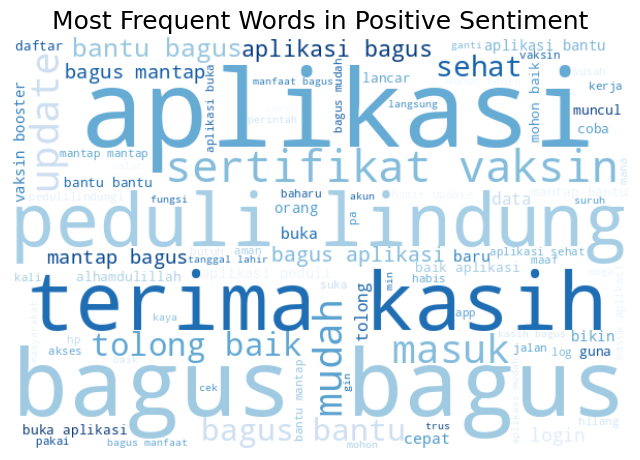

In [63]:
#Positive Sentiment Visualization
positive_text = df[df['sentiment'] == 'positive'].sort_values(by='sentiment_score', ascending=False)
list_words = ' '.join(positive_text['txt_stemming'].explode().dropna().astype(str))
wordcloud = WordCloud(width=600, height=400, background_color='white', colormap='Blues', min_font_size=10).generate(list_words)
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title('Most Frequent Words in Positive Sentiment', fontsize=18)
ax.imshow(wordcloud, interpolation='bilinear')
ax.axis('off')
plt.show()

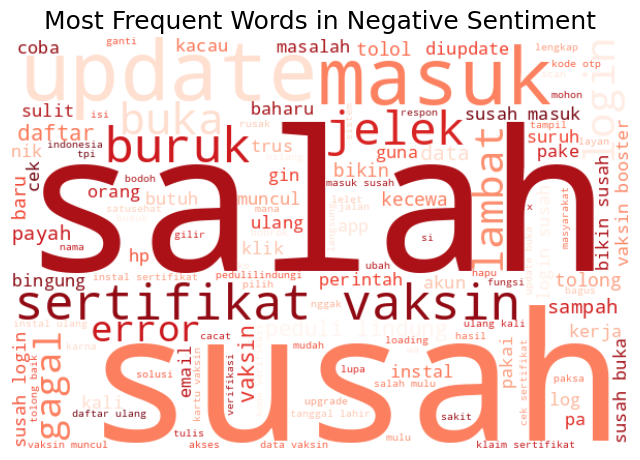

In [99]:
#Negative Sentiment Visualization
negative_text = df[df['sentiment'] == 'negative'].sort_values(by='sentiment_score', ascending=False)
list_words = ' '.join(negative_text['txt_stemming'].explode().dropna().astype(str))
wordcloud = WordCloud(width=600, height=400, background_color='white', colormap='Reds', min_font_size=10).generate(list_words)
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title('Most Frequent Words in Negative Sentiment', fontsize=18)
ax.imshow(wordcloud, interpolation='bilinear')
ax.axis('off')
plt.show()

## **7. Data Preparation & Feature Engineering**

In [100]:
#Separate features (X) and labels (y)
x = df['fix_text'].astype(str)
y = df['sentiment'].map({'positive': 2, 'negative': 1, 'neutral': 0})

In [101]:
#Performing TF-IDF vectorization for Traditional Machine Learning
tfidf_vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1,2), max_df=0.9)
X_tfidf = tfidf_vectorizer.fit_transform(x)
print(X_tfidf.shape)

(100000, 10000)


In [102]:
#Split Data: 80% training, 20% testing for Traditional Machine Learning
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

In [103]:
#Tokenizing & Padding for LSTM
tokenizer = Tokenizer(num_words=20000, oov_token='OOV')
tokenizer.fit_on_texts(x)
X = tokenizer.texts_to_sequences(x)
X = pad_sequences(X, maxlen=100)

In [104]:
#Split Data: 70% Train, 20% Test, 10% Validation for LSTM
X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_lstm, X_val_lstm, y_train_lstm, y_val_lstm = train_test_split(X_train_lstm, y_train_lstm, test_size=0.125, random_state=42)

## **8. Model Training & Evaluation**

### Traditional Machine Learning

In [105]:
#Perform SVM + TF-IDF model training (80% training, 20% testing)
svm_model = SVC(kernel='linear')
svm_model.fit(X_train, y_train)
y_train_pred_svm = svm_model.predict(X_train)
train_acc_svm = accuracy_score(y_train, y_train_pred_svm)
y_pred_svm = svm_model.predict(X_test)
test_acc_svm = accuracy_score(y_test, y_pred_svm)
print(f"SVM - Train Accuracy: {train_acc_svm:.4f} | Test Accuracy: {test_acc_svm:.4f}")
print("Classification Report (Test Set):")
print(classification_report(y_test, y_pred_svm))
print("="*60)

SVM - Train Accuracy: 0.9906 | Test Accuracy: 0.9828
Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      9718
           1       0.98      0.96      0.97      2985
           2       0.99      0.98      0.99      7297

    accuracy                           0.98     20000
   macro avg       0.98      0.98      0.98     20000
weighted avg       0.98      0.98      0.98     20000



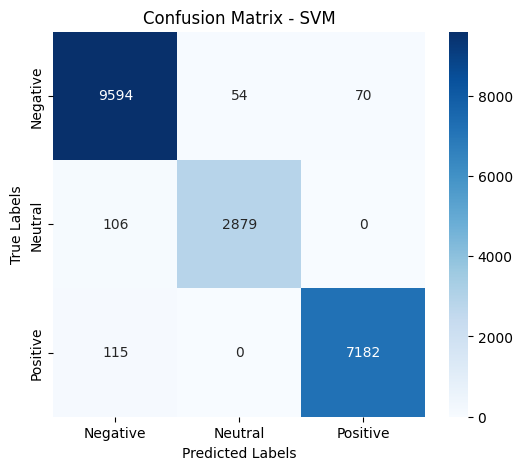

In [107]:
#Confusion Matrix Plot for SVM model
cm_svm = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - SVM')
plt.show()

In [108]:
#Perform Logistic Regression + TF-IDF model training (80% training, 20% testing)
logreg_model = LogisticRegression(max_iter=1000)
logreg_model.fit(X_train, y_train)
y_train_pred_logreg = logreg_model.predict(X_train)
train_acc_logreg = accuracy_score(y_train, y_train_pred_logreg)
y_pred_logreg = logreg_model.predict(X_test)
test_acc_logreg = accuracy_score(y_test, y_pred_logreg)
print(f"Logistic Regression - Train Accuracy: {train_acc_logreg:.4f} | Test Accuracy: {test_acc_logreg:.4f}")
print("Classification Report (Test Set):")
print(classification_report(y_test, y_pred_logreg))
print("="*60)

Logistic Regression - Train Accuracy: 0.9695 | Test Accuracy: 0.9478
Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.94      0.96      0.95      9718
           1       0.93      0.89      0.91      2985
           2       0.97      0.95      0.96      7297

    accuracy                           0.95     20000
   macro avg       0.95      0.94      0.94     20000
weighted avg       0.95      0.95      0.95     20000



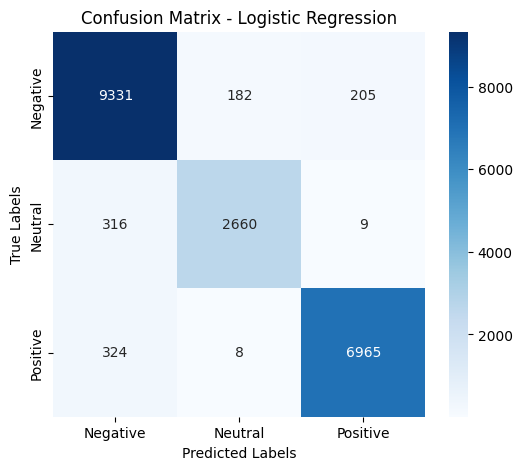

In [109]:
#Confusion Matrix Plot for Logistic Regression model
cm_logreg = confusion_matrix(y_test, y_pred_logreg)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_logreg, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()

### Deep Learning

In [110]:
#Perform LSTM model
lstm_model = Sequential([
    Embedding(input_dim=20000, output_dim=128, input_length=100),
    SpatialDropout1D(0.3),
    Bidirectional(LSTM(128, return_sequences=True)),
    Dropout(0.4),
    LSTM(64),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(3, activation='softmax')
])
lstm_model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=5e-4), metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_accuracy', patience=2, restore_best_weights=True, min_delta=0.001, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)
callbacks = [early_stopping, reduce_lr]

history = lstm_model.fit(
    X_train_lstm, y_train_lstm,
    validation_data=(X_val_lstm, y_val_lstm),
    epochs=25,
    batch_size=64,
    verbose=1,
    callbacks=callbacks
)

Epoch 1/25
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 32s 21ms/step - accuracy: 0.7961 - loss: 0.4553 - val_accuracy: 0.9787 - val_loss: 0.0709 - learning_rate: 5.0000e-04
Epoch 2/25
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 23s 21ms/step - accuracy: 0.9839 - loss: 0.0511 - val_accuracy: 0.9866 - val_loss: 0.0484 - learning_rate: 5.0000e-04
Epoch 3/25
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 23s 21ms/step - accuracy: 0.9933 - loss: 0.0232 - val_accuracy: 0.9885 - val_loss: 0.0427 - learning_rate: 5.0000e-04
Epoch 4/25
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 23s 21ms/step - accuracy: 0.9958 - loss: 0.0145 - val_accuracy: 0.9896 - val_loss: 0.0413 - learning_rate: 5.0000e-04
Epoch 5/25
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 41s 21ms/step - accuracy: 0.9970 - loss: 0.0111 - val_accuracy: 0.9896 - val_loss: 0.0453 - learning_rate: 5.0000e-04
Epoch 6/25
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 42s 22ms/step - accuracy: 0.9975 - loss: 0.0082 - val_accuracy: 0.9921 - val_loss: 0.0410 - learning_rate: 5.0000e-04
Epoch 7/25
1094/1094 ━━━━━━━━━━━━━━━━━━━

625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9927 - loss: 0.0385
LSTM Model Evaluation
Test Accuracy: 0.9924
Test Loss: 0.0399
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step

📌 Classification Report:
              precision    recall  f1-score   support

    negative       0.99      0.99      0.99      9718
     neutral       0.99      0.99      0.99      2985
    positive       1.00      0.99      0.99      7297

    accuracy                           0.99     20000
   macro avg       0.99      0.99      0.99     20000
weighted avg       0.99      0.99      0.99     20000



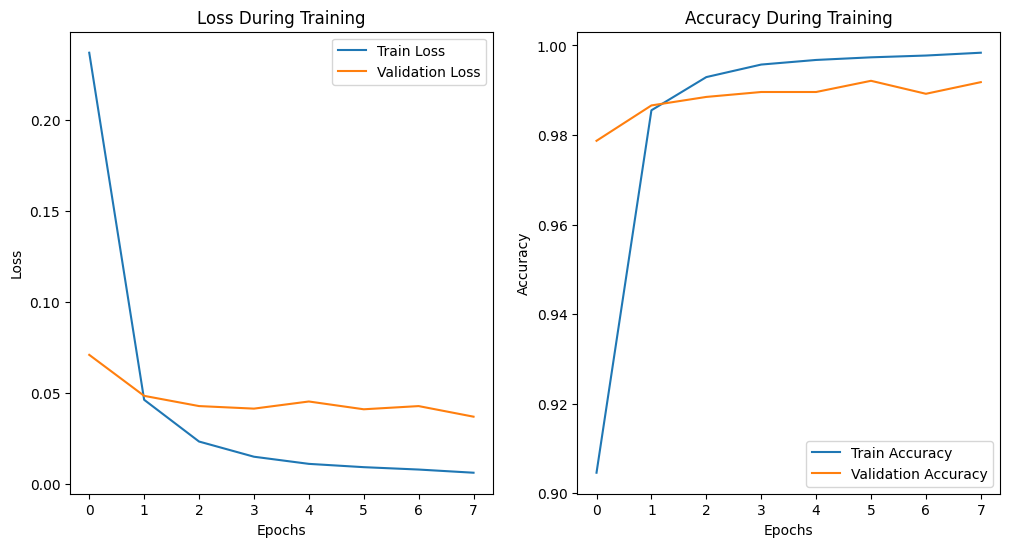

In [111]:
#LSTM Model Evaluation
test_loss, lstm_accuracy = lstm_model.evaluate(X_test_lstm, y_test_lstm)
print("LSTM Model Evaluation")
print(f"Test Accuracy: {lstm_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")
y_pred = np.argmax(lstm_model.predict(X_test_lstm), axis=1)
print("\n📌 Classification Report:")
print(classification_report(y_test_lstm, y_pred, target_names=['negative', 'neutral', 'positive']))
plt.figure(figsize=(12, 6))

#Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

#Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy During Training')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Model Evaluation

In [112]:
f1_svm = f1_score(y_test, y_pred_svm, average='macro')
f1_logreg = f1_score(y_test, y_pred_logreg, average='macro')
f1_lstm = f1_score(y_test_lstm, y_pred, average='macro')
results = [
    {
        'Model': 'SVM + TF-IDF (80/20)',
        'Accuracy': test_acc_svm,
        'F1-Score': f1_svm,
        'Split Ratio': '80/20',
        'Feature Type': 'TF-IDF'
    },
    {
        'Model': 'Logistic Regression + TF-IDF (80/20)',
        'Accuracy': test_acc_logreg,
        'F1-Score': f1_logreg,
        'Split Ratio': '80/20',
        'Feature Type': 'TF-IDF'
    },
    {
        'Model': 'LSTM + Embedding (80/20)',
        'Accuracy': lstm_accuracy,
        'F1-Score': f1_lstm,
        'Split Ratio': '80/20',
        'Feature Type': 'Word Embedding'
    }
]
df_summary = pd.DataFrame(results)
df_summary['Accuracy'] = df_summary['Accuracy'].apply(lambda x: f"{x:.2%}")
df_summary['F1-Score'] = df_summary['F1-Score'].apply(lambda x: f"{x:.2%}")
df_summary = df_summary.sort_values(by='Accuracy', ascending=False)
print("Summary of Model Results")
display(df_summary)

Summary of Model Results


,Model,Accuracy,F1-Score,Split Ratio,Feature Type
2,LSTM + Embedding (80/20),99.24%,99.18%,80/20,Word Embedding
0,SVM + TF-IDF (80/20),98.28%,98.09%,80/20,TF-IDF
1,Logistic Regression + TF-IDF (80/20),94.78%,94.06%,80/20,TF-IDF


## **9. Deployment Preparation**

In [113]:
import pickle

In [114]:
#Save TF-IDF Vectorizer
with open('tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf_vectorizer, f)

In [115]:
#Save Tokenizer
with open('tokenizer_lstm.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

In [116]:
#Save LSTM Model
lstm_model.save("lstm_sentiment_model.h5")

#Save SVM Model
with open("svm_model.pkl", "wb") as f:
    pickle.dump(svm_model, f)

#Save Logistic Regression Model
with open("logreg_model.pkl", "wb") as f:
    pickle.dump(logreg_model, f)

In [117]:
#Save LSTM Model with different types
lstm_model.save("lstm_sentiment_model.keras")

## **10. Result Summary and Conclusion**

### 📊**Summary of Model Performance**

This project evaluated three different sentiment classification models using a consistent 80:20 train-test split ratio. The first model, **LSTM with Word Embedding**, achieved the highest performance with an accuracy of **99.24%** and an F1-score of **99.18%**. This deep learning approach demonstrated its strength in capturing contextual meaning in textual data. The second model, **Support Vector Machine (SVM) with TF-IDF**, also performed remarkably well, achieving an accuracy of **98.28%** and an F1-score of **98.09%**, proving that traditional machine learning models remain effective when combined with strong feature extraction methods like TF-IDF. Lastly, **Logistic Regression with TF-IDF** yielded an accuracy of **94.78%** and an F1-score of **94.06%**, making it a lighter and faster alternative while still maintaining good performance.

---

### ✅**Conclusion**

1. **The LSTM model with Word Embedding outperformed all other models**, indicating its capability to understand the semantic structure of Indonesian reviews better than traditional models.

2. **SVM with TF-IDF remains a strong and reliable choice** when computational resources are limited or when a simpler model is preferred. It balances accuracy and speed well.

3. **Logistic Regression**, while not the top performer, still achieved solid results and could be ideal for rapid prototyping or use cases that prioritize interpretability and low latency.

---

### 🧠**Insights and Recommendations**

- **Feature extraction method plays a vital role** in model performance. Word Embeddings significantly enhanced LSTM's ability to interpret sentiment by understanding word context, compared to TF-IDF which relies solely on frequency-based patterns.

- **For production-level applications**, the LSTM model is suitable when aiming for high precision and access to ample computing power. On the other hand, SVM offers a reliable trade-off between accuracy and efficiency.

- As part of the model deployment pipeline, **all models along with their respective vectorizers (TF-IDF or Tokenizer)** have been saved, enabling seamless inference on unseen data moving forward.
